## Sprint6 機械学習スクラッチ決定木

In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [33]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
X = pd.DataFrame(X)
y = pd.DataFrame(y)
X.columns = ["sepal_length" , "sepal_width" , "petal_length" , "petal_width"]
y.columns = ["Species"]
df = pd.concat([X , y] , axis = 1)
df_cn = df.query("Species == [1,2]").loc[: , :]
X = df_cn.iloc[: , 2:4].values
y = df_cn.iloc[: , -1].values
y[y==2]=0
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## 【問題1】ジニ不純度を求める関数

I(t):ジニ不純度

t : ノードのインデックス

i: クラスのインデックス

K: クラスの数

Ci: i番目のクラス

P(Ci|t):　t番目のノードにおけるCiの割合

Nt,i: t番目のノードのi番目のクラスに属するサンプル数

Nt,all: t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較してください。

例

クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500

クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667

クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480

クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [34]:
def gini_impurity(y):
    n = len(y)
    num = np.unique(y)
    a = 0
    for i in num:
        a += (len(y[y==i])/n)**2
    
    return 1 - a

In [35]:
gini_impurity(y)

0.5

In [36]:
def gini_impurity(y):
    val = 1
    classes = np.unique(y)
    numdata = len(y)
    
    for c in classes:
        a = (len(y[y==c])) / numdata
        val -=  a** 2.0
    return val

In [37]:
gini_impurity(y)

0.5

## 【問題2】情報利得を求める関数

IG:情報利得

I(t):ジニ不純度

p: 親ノードを示すインデックス

left: 左側のノードを示すインデックス

right: 右側のノードを示すインデックス

まずは簡単な例を作り、手計算と関数の結果を比較してください。

In [38]:
def info_gain(t_p, t_l, t_r):
    in_g = gini_impurity(t_p) - (len(t_l)/len(t_p))*gini_impurity(t_l) - (len(t_r)/len(t_p))*gini_impurity(t_r)
    return in_g

In [39]:
clas1 = np.zeros(30)
clas2 = np.ones(35)
h= np.concatenate([clas1, clas2], 0)
clas_left1 = np.zeros(10)
clas_left2 = np.ones(30)
y_left = np.concatenate([clas_left1, clas_left2], 0)
clas_right1 = np.zeros(20)
clas_right2 = np.ones(5)
y_right = np.concatenate([clas_right1, clas_right2], 0)
info_gain(h,y_left,y_right)

0.14319526627218943

## 【問題3】深さ1の決定木分類器クラスの作成

In [40]:
left_list = []
right_list = []
num_features = X.shape[1]
for i in range(num_features):
    for threshold in np.unique(X[: , i]):
        left = np.array(np.where([X[: , i] <= threshold])[1])
        right = X[: , i][X[: , i] > threshold]
        print(threshold , left)

3.0 [48]
3.3 [ 7 43 48]
3.5 [ 7 10 29 43 48]
3.6 [ 7 10 14 29 43 48]
3.7 [ 7 10 14 29 31 43 48]
3.8 [ 7 10 14 29 30 31 43 48]
3.9 [ 7  9 10 14 19 29 30 31 32 43 48]
4.0 [ 3  7  9 10 12 14 19 21 29 30 31 32 39 42 43 48]
4.1 [ 3  7  9 10 12 14 17 19 21 29 30 31 32 38 39 42 43 48 49]
4.2 [ 3  7  9 10 11 12 14 17 19 21 29 30 31 32 38 39 42 43 44 45 46 48 49]
4.3 [ 3  7  9 10 11 12 14 17 19 21 24 29 30 31 32 38 39 42 43 44 45 46 47 48
 49]
4.4 [ 3  7  9 10 11 12 14 15 17 19 21 24 25 29 30 31 32 37 38 39 40 42 43 44
 45 46 47 48 49]
4.5 [ 1  3  5  7  9 10 11 12 14 15 16 17 18 19 21 24 25 28 29 30 31 32 34 35
 37 38 39 40 42 43 44 45 46 47 48 49 56]
4.6 [ 1  3  4  5  7  8  9 10 11 12 14 15 16 17 18 19 21 24 25 28 29 30 31 32
 34 35 37 38 39 40 41 42 43 44 45 46 47 48 49 56]
4.7 [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25 28
 29 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 56]
4.8 [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25
 26

In [41]:
info_list = []
max_list = []
threshold_list = []
for i in range(X.shape[1]):
    for threshold in np.unique(X[: , i]):
        left = np.array(np.where([X[: , i] <= threshold])[1])
        right = np.array(np.where([X[: , i] > threshold])[1])
#         print("fff",np.unique(X[: , i]).shape)
#         print(threshold , y[right].shape)
#         print(info_gain(y , y[left] , y[right]))
#         print(y[right].shape , y[left].shape)
        threshold_list = np.append(threshold_list , threshold)
        info_list = np.append(info_list , info_gain(y , y[left] , y[right]))
max_list = np.append(max_list , info_list.max())
max_index = np.argmax(info_list)
p_threshold = threshold_list[max_index]

In [42]:
y_left

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [43]:
threshold_list

array([3. , 3.3, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
       4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8,
       5.9, 6. , 6.1, 6.3, 6.4, 6.6, 6.7, 6.9, 1. , 1.1, 1.2, 1.3, 1.4,
       1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5])

In [44]:
info_list

array([0.00505051, 0.01546392, 0.02631579, 0.03191489, 0.03763441,
       0.04347826, 0.06179775, 0.0952381 , 0.11728395, 0.14935065,
       0.16666667, 0.20422535, 0.26276276, 0.30083333, 0.37353535,
       0.36994798, 0.35507246, 0.32840722, 0.25757576, 0.23529412,
       0.21428571, 0.19444444, 0.16666667, 0.11728395, 0.0952381 ,
       0.07471264, 0.06179775, 0.04945055, 0.03191489, 0.02631579,
       0.02083333, 0.01546392, 0.00505051, 0.        , 0.03763441,
       0.05555556, 0.08823529, 0.19444444, 0.25086806, 0.35336538,
       0.38782051, 0.38969404, 0.25757576, 0.20422535, 0.14935065,
       0.10240964, 0.08139535, 0.03191489, 0.01546392, 0.        ])

In [45]:
np.argmax(info_list)

41

In [46]:
max_index

41

In [47]:
p_threshold

1.7

In [57]:
class ScratchDecesionTreeClassifier():


    def __init__(self, num_iter = 1000, bias = True, verbose = True):
        self.iter = num_iter
        self.bias = bias
        self.verbose = verbose
        self.g_imp = None
        self.info_g = None
        self.y_left = np.array([])
        judge_1 = None
        self.whethere = None
     
    def _get_gini_impurity(self, y):
        numdata = len(y)
        classes = np.unique(y)
        a = 0
        for c in classes:
            a += (len(y[y==c])/numdata)**2
        return 1 - a
    
    def _get_info_gain(self , y):
        info_g = self.g_imp  -  (len(self.y_left)/len(y))*self.g_imp_left  -  (len(self.y_right)/len(y))*self.g_imp_right
        return info_g
    
                
    def fit(self , X , y):
        info_list = []
        max_list = []
        threshold_list = []
        for i in range(X.shape[1]):
            for threshold in np.unique(X[: , i]):
                left = np.array(np.where([X[: , i] <= threshold])[1])
                right = np.array(np.where([X[: , i] > threshold])[1])
#                 print(info_gain(y , y[left] , y[right]))
#                 print(y[right].shape , y[left].shape) 
                self.y_left = y[left]
                self.y_right = y[right]
                threshold_list = np.append(threshold_list , threshold)
                info_list = np.append(info_list , info_gain(y , y[left] , y[right]))
        

        for i in range(self.iter):
            self.g_imp = self._get_gini_impurity(y)
            self.g_imp_left = self._get_gini_impurity(self.y_left)
            self.g_imp_right = self._get_gini_impurity(self.y_right)
            self.info_g = self._get_info_gain(y)
       
    

        max_list = np.append(max_list , info_list.max())
        max_index = np.argmax(info_list)
        self.p_threshold = threshold_list[max_index]
        

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.p_threshold)


    def predict(self, X):
        result_array = np.zeros(X.shape[0])
        y_pred = np.where(X[:,1] <= p_threshold ,1,0)
#         y_pred_r = np.where(X[:,0] > p_threshold ,1,0)

        return y_pred

In [58]:
tree = ScratchDecesionTreeClassifier()
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(
               X , y , test_size = 0.25)

In [59]:
tree.fit(X_train,y_train)

1.7


In [60]:
tree.predict(X_test)

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0])

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    marker = ["o" , "^"]

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker=marker[i])
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
#     plt.scatter(svm.Xn[: , 0], svm.Xn[:,1] , color = "white")
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

## 【問題6】指標値の算出

In [62]:
from sklearn.metrics import accuracy_score , precision_score , recall_score, f1_score ,  confusion_matrix

In [63]:
def learn_model(X , y , model = tree):
    X_train , X_test , y_train , y_test = train_test_split(
                  X , y , test_size = 0.25)
    model.fit(X_train , y_train)
    y_pred = model.predict(X_test)  
    score = accuracy_score(y_test , y_pred)
    pre_score = precision_score(y_test , y_pred)
    re_score = recall_score(y_test , y_pred)
    f_score = f1_score(y_test , y_pred)
    con_mat = confusion_matrix(y_test , y_pred)
    
    print("accuracy_score :" , score)
    print("precision_score :" , pre_score)
    print("recall_score :" , re_score)
    print("f1_score :" , f_score)
    print("confusion_matrix :" , con_mat)

In [64]:
learn_model(X , y)

1.7
accuracy_score : 0.88
precision_score : 0.875
recall_score : 0.9333333333333333
f1_score : 0.9032258064516129
confusion_matrix : [[ 8  2]
 [ 1 14]]


## 【問題7】決定領域の可視化


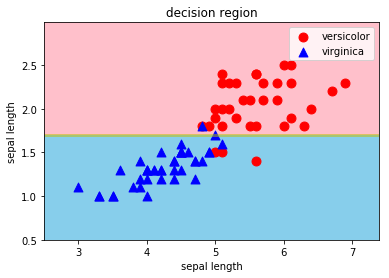

In [65]:
decision_region(X_train , y_train , tree ,  title='decision region', xlabel='sepal length', 
                             ylabel='sepal length' )

In [66]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]
# y[y==1]=0
# y[y==-1]=1

In [67]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(
               X , y , test_size = 0.25)

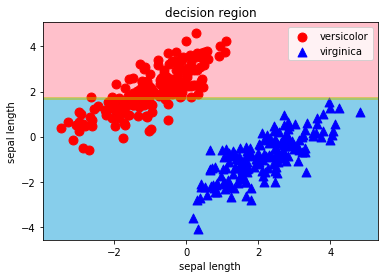

In [68]:
decision_region(X_train , y_train , tree ,  title='decision region', xlabel='sepal length', 
                             ylabel='sepal length' )

## 【問題8】決定木の利用場面

・処理結果が解釈しやすく妥当性を判断しやすい

・「分類」にも「回帰」にも利用可能